In [ ]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [ ]:
def get_tr_and_te(y, tx, k_indices, k):
    te_y = y[k_indices[k]]
    te_tx = tx[k_indices[k]]
    tr_indices = []
    for i, indices in zip(range(len(k_indices)), k_indices):
        if i != k:
            tr_indices.append(indices)
            
    tr_indices = np.array(tr_indices).flatten()
    return tx[tr_indices], y[tr_indices], te_tx, te_y

In [ ]:
y1 = np.array([1,1,-1,-1, 1, 1])
x1 = np.array([1,2,3,4,5,6])
k = 3
k_indices = build_k_indices(y1, k, 23)
print(k_indices)
print(get_tr_and_te(y1, x1, k_indices, 0))

In [ ]:
x = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])

np.polynomial.polynomial.polyvander(x, 5).T
expand_features_polynomial(x, 2)

In [ ]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return np.exp(t)/(1+np.exp(t))

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    cost = 0.0
    n = len(y)
    for i in range(0, len(y)):
        cost += (np.log(1 + np.exp(tx[i].T@w)) - y[i]*tx[i].T@w)/n
    
    return cost

def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return tx.T@(sigmoid(tx@w) - y)

def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w)
    
    gradient = calculate_gradient(y, tx, w)
    
    w = w - gamma*gradient
    
    return loss, w

def my_logistic_reg(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    losses = []
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 1 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return w, loss

In [ ]:
def cross_validation_reg_log_regr(y, tx, w_initial, max_iters, gammas, lambdas_, k_fold, seed):
    k_indices = build_k_indices(y, k_fold, seed)
    tr_losses = np.zeros((len(gammas), len(lambdas_)))
    te_losses = np.zeros((len(gammas), len(lambdas_)))

    for gamma_index,gamma in zip(range(len(gammas)), gammas):
        for lambda_index, lambda_ in zip(range(len(lambdas_)),lambdas_):
            tr_k_losses = np.zeros((k_fold))
            te_k_losses = np.zeros((k_fold))
            weights_k = np.zeros((k_fold))
            for k in range(k_fold):
                tr_tx_k, tr_y_k, te_tx_k, te_y_k = get_tr_and_te(y, tx, k_indices, k)
                
                w_k, tr_loss_k = reg_logistic_regression(tr_y_k, tr_tx_k, lambda_, w_initial, max_iters, gamma)
                #w_k, tr_loss_k = my_logistic_reg(tr_y_k, tr_tx_k, w_initial, max_iters, gamma)
                
                te_loss_k = calculate_loss_sigmoid(te_y_k, te_tx_k, w_k)
                
                tr_k_losses[k] = tr_loss_k
                te_k_losses[k] = te_loss_k
                
            tr_loss = np.mean(tr_k_losses)
            te_loss = np.mean(te_k_losses)
            weight = np.mean(weights_k)
            tr_losses[gamma_index][lambda_index] = tr_loss
            te_losses[gamma_index][lambda_index] = te_loss
            
            print(tr_loss)
            print(te_loss)
            argmin = np.argmin(te_losses)
            gamma_idx = argmin//len(lambdas_)
            lambda_idx = argmin%len(lambdas_)
            gamma = gammas[gamma_idx]
            lambda_ = lambdas_[lambda_idx]

    return tr_losses, te_losses, gamma, lambda_

In [ ]:
#Global variables
max_iters = 2500
k_fold = 3
seed = 142
lambdas_ = np.array([100, 1000, 10000])
gammas = np.array([10**(-i) for i in range(5,10)])
print("gammas = ", gammas)
w_initial = np.array([0.0 for i in range(tX.shape[1])])
tX_standardized, tr_mean, tr_std = standardize(tX)

#to work with loss
y = np.array([int((y[i] + 1)/2) for i in range(len(y))])

In [ ]:
tr_losses, te_losses, gamma, lambda_ = cross_validation_reg_log_regr(y, tX_standardized, w_initial, max_iters, gammas, lambdas_, k_fold, seed)

In [ ]:
#tX_standardized, tr_mean, tr_std = standardize(tX)
#w, loss = least_squares(y,tX)

# Change lambdas and gammas seeing this result to reduce computation time
before best was 
gamma =  1e-06  lambda =  100
At iteration 6000, loss = 0.5555634390152187

In [ ]:
#Global variables
max_iters = 3000
k_fold = 3
seed = 142
lambdas_ = np.array([1, 10, 100, 1000])
gammas = np.array([10**(-i) for i in range(6,8)])
print("gammas = ", gammas)
w_initial = np.array([0.0 for i in range(tX.shape[1])])
tX_standardized, tr_mean, tr_std = standardize(tX)

#to work with loss
y = np.array([int((y[i] + 1)/2) for i in range(len(y))])

In [ ]:
tr_losses, te_losses, gamma, lambda_ = cross_validation_reg_log_regr(y, tX_standardized, w_initial, max_iters, gammas, lambdas_, k_fold, seed)

In [ ]:
print("gamma = ", gamma, " lambda = ", lambda_)
w, loss = reg_logistic_regression(y, tX_standardized, lambda_, w_initial, 30000, gamma)

# Best with regularized logistic regression
0.737

gamma =  1e-06  lambda =  10
At iteration 28000, loss = 0.5304865390677854

In [ ]:
DATA_TEST_PATH = 'data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test_standardized = (tX_test- tr_mean)/tr_std

In [ ]:
OUTPUT_PATH = 'data/output.csv' 
y_pred = predict_labels(w, tX_test_standardized)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
te_losses_gamma_10e6 = np.array(list(zip(te_losses[0], lambdas_)))
te_losses_gamma_10e7 = np.array(list(zip(te_losses[1], lambdas_)))

In [ ]:
plt.plot([te_losses_gamma_10e6[i][1] for i in range(len(te_losses_gamma_10e6))], [te_losses_gamma_10e6[i][0] for i in range(len(te_losses_gamma_10e6))])

In [ ]:
te_losses_gamma_10e6

# Let's try with cleaned data

it is also the clean path for my part

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def get_tr_and_te(y, tx, k_indices, k):
    te_y = y[k_indices[k]]
    te_tx = tx[k_indices[k]]
    tr_indices = []
    for i, indices in zip(range(len(k_indices)), k_indices):
        if i != k:
            tr_indices.append(indices)
            
    tr_indices = np.array(tr_indices).flatten()
    return tx[tr_indices], y[tr_indices], te_tx, te_y

def cross_validation_reg_log_regr(y, tx, w_initial, max_iters, gammas, lambdas_, k_fold, seed):
    k_indices = build_k_indices(y, k_fold, seed)
    tr_losses = np.zeros((len(gammas), len(lambdas_)))
    te_losses = np.zeros((len(gammas), len(lambdas_)))

    for gamma_index,gamma in zip(range(len(gammas)), gammas):
        for lambda_index, lambda_ in zip(range(len(lambdas_)),lambdas_):
            tr_k_losses = np.zeros((k_fold))
            te_k_losses = np.zeros((k_fold))
            weights_k = np.zeros((k_fold))
            for k in range(k_fold):
                tr_tx_k, tr_y_k, te_tx_k, te_y_k = get_tr_and_te(y, tx, k_indices, k)
                
                w_k, tr_loss_k = reg_logistic_regression(tr_y_k, tr_tx_k, lambda_, w_initial, max_iters, gamma)
                
                te_loss_k = calculate_loss_sigmoid(te_y_k, te_tx_k, w_k)
                
                tr_k_losses[k] = tr_loss_k
                te_k_losses[k] = te_loss_k
                
            tr_loss = np.mean(tr_k_losses)
            te_loss = np.mean(te_k_losses)
            weight = np.mean(weights_k)
            tr_losses[gamma_index][lambda_index] = tr_loss
            te_losses[gamma_index][lambda_index] = te_loss
            
            print(tr_loss)
            print(te_loss)
            argmin = np.argmin(te_losses)
            gamma_idx = argmin//len(lambdas_)
            lambda_idx = argmin%len(lambdas_)
            gamma = gammas[gamma_idx]
            lambda_ = lambdas_[lambda_idx]

    return tr_losses, te_losses, gamma, lambda_

In [ ]:
#Global variables
max_iters = 3000
k_fold = 3
seed = 142
lambdas_ = np.array([1, 10, 100, 1000, 10000])
gammas = np.array([10**(-i) for i in range(6,10)])

tX_cleaned_standardized, tr_cleaned_mean, tr_cleaned_std = standardize(remove_wrong_columns(tX))
w_initial = np.array([0.0 for i in range(tX_cleaned_standardized.shape[1])])

#to work with loss
y = np.array([int((y[i] + 1)/2) for i in range(len(y))])

In [ ]:
tr_losses, te_losses, gamma, lambda_ = cross_validation_reg_log_regr(y, tX_cleaned_standardized, w_initial, max_iters, gammas, lambdas_, k_fold, seed)

In [ ]:
print("gamma = ", gamma, " lambda = ", lambda_)
w, loss = reg_logistic_regression(y, tX_cleaned_standardized, lambda_, w_initial, 30000, gamma)

In [ ]:
DATA_TEST_PATH = 'data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test_cleaned_standardized = (remove_wrong_columns(tX_test)- tr_cleaned_mean)/tr_cleaned_std

In [ ]:
OUTPUT_PATH = 'data/output.csv' 
y_pred = predict_labels(w, tX_test_cleaned_standardized)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
plt.semilogx(lambdas_, te_losses[0], marker=".", color='b', label='test error with gamma={}'.format(gammas[0]))
plt.semilogx(lambdas_, te_losses[1], marker=".", color='r', label='test error with gamma={}'.format(gammas[1]))
plt.semilogx(lambdas_, te_losses[2], marker=".", color='g', label='test error with gamma={}'.format(gammas[2]))
plt.semilogx(lambdas_, te_losses[3], marker=".", color='y', label='test error with gamma={}'.format(gammas[3]))
plt.xlabel("lambda")
plt.ylabel("error")
plt.title("regularized logistic regression")
plt.legend(loc=2)
plt.grid(True)
plt.savefig("title")

# Code to copy for final project
it computes with regularized logistic regression for raw and clean data, and makes a plot of errors

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *

In [2]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def get_tr_and_te(y, tx, k_indices, k):
    te_y = y[k_indices[k]]
    te_tx = tx[k_indices[k]]
    tr_indices = []
    for i, indices in zip(range(len(k_indices)), k_indices):
        if i != k:
            tr_indices.append(indices)
            
    tr_indices = np.array(tr_indices).flatten()
    return tx[tr_indices], y[tr_indices], te_tx, te_y

def cross_validation_reg_log_regr(y, tx, w_initial, max_iters, gammas, lambdas_, k_fold, seed):
    k_indices = build_k_indices(y, k_fold, seed)
    tr_losses = np.zeros((len(gammas), len(lambdas_)))
    te_losses = np.zeros((len(gammas), len(lambdas_)))

    for gamma_index,gamma in zip(range(len(gammas)), gammas):
        for lambda_index, lambda_ in zip(range(len(lambdas_)),lambdas_):
            tr_k_losses = np.zeros((k_fold))
            te_k_losses = np.zeros((k_fold))
            weights_k = np.zeros((k_fold))
            for k in range(k_fold):
                tr_tx_k, tr_y_k, te_tx_k, te_y_k = get_tr_and_te(y, tx, k_indices, k)
                
                w_k, tr_loss_k = reg_logistic_regression(tr_y_k, tr_tx_k, lambda_, w_initial, max_iters, gamma)
                
                te_loss_k = calculate_loss_sigmoid(te_y_k, te_tx_k, w_k)
                
                tr_k_losses[k] = tr_loss_k
                te_k_losses[k] = te_loss_k
                
            tr_loss = np.mean(tr_k_losses)
            te_loss = np.mean(te_k_losses)
            weight = np.mean(weights_k)
            tr_losses[gamma_index][lambda_index] = tr_loss
            te_losses[gamma_index][lambda_index] = te_loss
            
            print(tr_loss)
            print(te_loss)
            argmin = np.argmin(te_losses)
            gamma_idx = argmin//len(lambdas_)
            lambda_idx = argmin%len(lambdas_)
            gamma = gammas[gamma_idx]
            lambda_ = lambdas_[lambda_idx]

    return tr_losses, te_losses, gamma, lambda_

def make_plots_reg_log_regr(te_losses, lambdas_, gammas, save_name, title):
    plt.semilogx(lambdas_, te_losses[0], marker=".", color='b', label='test error with gamma={}'.format(gammas[0]))
    plt.semilogx(lambdas_, te_losses[1], marker=".", color='r', label='test error with gamma={}'.format(gammas[1]))
    plt.semilogx(lambdas_, te_losses[2], marker=".", color='g', label='test error with gamma={}'.format(gammas[2]))
    plt.semilogx(lambdas_, te_losses[3], marker=".", color='y', label='test error with gamma={}'.format(gammas[3]))
    plt.xlabel("lambda")
    plt.ylabel("error")
    plt.title(title)
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig(save_name)

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [6]:
#Global variables for RAW DATA and CLEANED DATA
max_iters = 3000
k_fold = 3
seed = 142
lambdas_ = np.array([1, 10, 100, 1000, 10000])
gammas = np.array([10**(-i) for i in range(6,10)])

tX_standardized, tr_mean, tr_std = standardize(tX)
tX_cleaned_standardized, tr_cleaned_mean, tr_cleaned_std = standardize(remove_wrong_columns(tX))


w_initial_raw = np.array([0.0 for i in range(tX_standardized.shape[1])])

w_initial_clean = np.array([0.0 for i in range(tX_cleaned_standardized.shape[1])])

#to work with loss
y = np.array([int((y[i] + 1)/2) for i in range(len(y))])

In [8]:
tr_losses, te_losses, gamma, lambda_ = cross_validation_reg_log_regr(y, tX_standardized, w_initial_raw, max_iters, gammas, lambdas_, k_fold, seed)

At iteration 0, loss = 0.6931471805599424
At iteration 1000, loss = 0.5684430043539948
At iteration 2000, loss = 0.5583692247724278
At iteration 0, loss = 0.5511264311615018
At iteration 1000, loss = 0.5460653088954509
At iteration 2000, loss = 0.5422474944368155
At iteration 0, loss = 0.5394698316506356
At iteration 1000, loss = 0.5371208207547129
At iteration 2000, loss = 0.5352654732448939
0.5414543076955408
45091.577688956146
At iteration 0, loss = 0.5370512202125811
At iteration 1000, loss = 0.5364209571518908
At iteration 2000, loss = 0.5359194013519164
At iteration 0, loss = 0.5357680009964346
At iteration 1000, loss = 0.5354509790411728
At iteration 2000, loss = 0.5351932177944126
At iteration 0, loss = 0.5350665959556371
At iteration 1000, loss = 0.534877907388126
At iteration 2000, loss = 0.5347233412289472
0.5350280068978794
44142.23929225857
At iteration 0, loss = 0.5866304758119318
At iteration 1000, loss = 0.574730786235232
At iteration 2000, loss = 0.5684202081603393
At 

In [9]:
tr_losses_clean, te_losses_clean, gamma_clean, lambda_clean = cross_validation_reg_log_regr(y, tX_cleaned_standardized, w_initial_clean, max_iters, gammas, lambdas_, k_fold, seed)

At iteration 0, loss = 0.6931471805599424
At iteration 1000, loss = 0.548942295593559
At iteration 2000, loss = 0.5481410481545872
At iteration 0, loss = 0.548940687147835
At iteration 1000, loss = 0.5488184961001142
At iteration 2000, loss = 0.548721196128946
At iteration 0, loss = 0.5489163591427096
At iteration 1000, loss = 0.548803501106298
At iteration 2000, loss = 0.5487149462226939
0.548394227294338
45697.92054721483
At iteration 0, loss = 0.547822008166694
At iteration 1000, loss = 0.5477448929082285
At iteration 2000, loss = 0.5476891290960691
At iteration 0, loss = 0.5486428159133002
At iteration 1000, loss = 0.5485842944502651
At iteration 2000, loss = 0.5485351567648689
At iteration 0, loss = 0.5487800989651782
At iteration 1000, loss = 0.548709690786732
At iteration 2000, loss = 0.5486664921526301
0.5482508524188551
45643.26764156718
At iteration 0, loss = 0.5529748979276283
At iteration 1000, loss = 0.5524347282802105
At iteration 2000, loss = 0.5521959503380316
At iterat

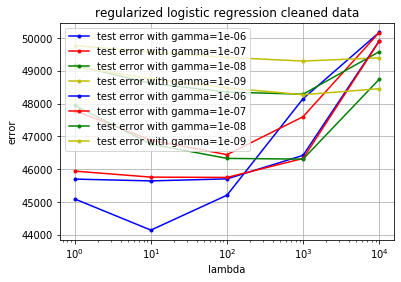

In [10]:
make_plots_reg_log_regr(te_losses, lambdas_, gammas, "raw_data_reg_log_regr", "regularized logistic regression raw data")
make_plots_reg_log_regr(te_losses_clean, lambdas_, gammas, "clean_data_reg_log_regr", "regularized logistic regression cleaned data")